In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
Features=pd.read_csv("../data/data_proccesed.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Y -= 1

# encoder = OneHotEncoder()
# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [75]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.02)
scheduler = LearningRateScheduler(custom_scheduler)

normalizer = layers.Normalization()
normalizer.adapt(X)

k=6
while True:
    model = models.Sequential([
        layers.Input(shape=(x_train.shape[1], 1)),
        normalizer,
        layers.Conv1D(2**(k+4), 1, activation='relu'),
        layers.Conv1D(2**(k+3), 1, activation='relu'),
        layers.MaxPooling1D(),
        layers.Conv1D(2**(k+2), 1, activation='relu'),
        layers.MaxPooling1D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(2**(k+4), activation='relu'),
        layers.Dense(9, activation='softmax'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    history=model.fit(x_train, y_train, epochs=80, batch_size=32, validation_data=(x_test, y_test),callbacks=scheduler)
    nul,acc=model.evaluate(x_test,y_test)
    if acc>0.44:
        model.save('../model/')
        break


Epoch 1/80
36/36 [==============================] - 1s 15ms/step - loss: 128616.0156 - accuracy: 0.1432 - val_loss: 411.4399 - val_accuracy: 0.1944 - lr: 0.0010
Epoch 2/80
36/36 [==============================] - 0s 5ms/step - loss: 213.2463 - accuracy: 0.1675 - val_loss: 200.7460 - val_accuracy: 0.1215 - lr: 0.0010
Epoch 3/80
36/36 [==============================] - 0s 5ms/step - loss: 100.1270 - accuracy: 0.2535 - val_loss: 1.9398 - val_accuracy: 0.3264 - lr: 0.0010
Epoch 4/80
36/36 [==============================] - 0s 5ms/step - loss: 5.7947 - accuracy: 0.2726 - val_loss: 1.8273 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 5/80
36/36 [==============================] - 0s 5ms/step - loss: 3.7942 - accuracy: 0.3012 - val_loss: 1.7362 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 6/80
36/36 [==============================] - 0s 5ms/step - loss: 1.7078 - accuracy: 0.3220 - val_loss: 1.7049 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 7/80
36/36 [==============================] - 0s 5ms/step - lo

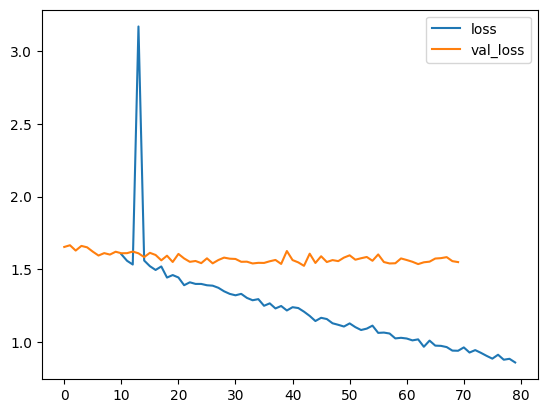

In [83]:
metrics = history.history
plt.plot(history.epoch[10:], metrics['loss'][10:], metrics['val_loss'][10:])
plt.legend(['loss', 'val_loss'])
plt.show()

9/9 [==============================] - 0s 24ms/step
Test set accuracy: 45%


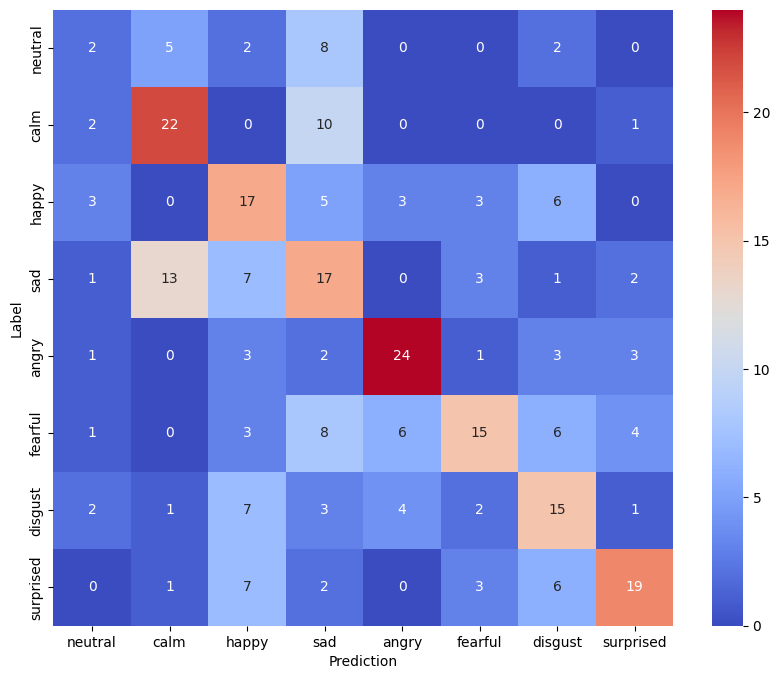

In [82]:
commands=["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [79]:
model.evaluate(x_test,y_test)

9/9 [==============================] - 0s 25ms/step - loss: 1.5499 - accuracy: 0.4549


[1.5498956441879272, 0.4548611044883728]